In [21]:
import os
import sys
import polars as pl
import polars.selectors as cs

from datetime import datetime

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import PROCESSED_PICARRO_DATA_DIRECTORY, POSTPROCESSED_DATA_DIRECTORY
from utils.import_data import import_acropolis_system_data
from utils.plot_dataframes import plot_column_difference, plot_column

assert(os.path.exists(DATA_DIRECTORY))
assert(os.path.exists(POSTPROCESSED_DATA_DIRECTORY))

In [22]:
# functions
def join_picarro_data(df: pl.DataFrame, df_p: pl.DataFrame) -> pl.DataFrame:
    return df.sort("datetime") \
    .join(df_p, on="datetime") \
    .group_by_dynamic("datetime", every='1h', group_by=["system_id", "system_name"]) \
    .agg([
            cs.numeric().mean(),
            pl.col("gmp343_corrected").std().alias("gmp343_corrected_std"),
            pl.col("gmp343_corrected").var().alias("gmp343_corrected_var")
        ]) 
            
def calculate_performance_metrics(df: pl.DataFrame, col:str = "gmp343_corrected") -> pl.DataFrame:
    return df.with_columns(diff = pl.col("CO2") - pl.col(col)) \
        .filter(pl.col("diff").is_not_nan()) \
        .select([
            (pl.col("diff").mean()).alias("mean_full_deployment"),
            (pl.col("diff").pow(2).mean()).alias("mse_full_deployment"),
            (pl.col("diff").pow(2).mean().sqrt()).alias("rmse_full_deployment")
        ])

In [23]:
df_p_icos = pl.scan_parquet(os.path.join(PROCESSED_PICARRO_DATA_DIRECTORY,"Calibrated_1_min_ICOS_Picarro_G2401_529.parquet"))

start_date = datetime(2025, 2, 17, 15, 0, 0)
end_date = datetime(2025, 2 , 24, 7, 0, 0)

df_p_icos = df_p_icos.rename({"creation_timestamp": "datetime", "picarro_corrected": "CO2"}) \
    .select(["datetime", "CO2"]) \
    .with_columns(pl.col("datetime").cast(pl.Datetime("ms"))) \
    .filter(pl.col("datetime").is_between(start_date, end_date)) \
    .with_columns(system_name = pl.lit("Picarro_ICOS")) \
    .with_columns(system_id = pl.lit(529)) \
    .with_columns(pl.col("system_id").cast(pl.Int64)) \
    .collect()

In [24]:
df_3 = import_acropolis_system_data(years = [2024,2025], 
                                    target_directory=POSTPROCESSED_DATA_DIRECTORY, 
                                    id=3, 
                                    prefix="1min").collect().pipe(join_picarro_data, df_p_icos)
df_6 = import_acropolis_system_data(years = [2024,2025], 
                                    target_directory=POSTPROCESSED_DATA_DIRECTORY, 
                                    id=6, 
                                    prefix="1min").collect().pipe(join_picarro_data, df_p_icos)

In [25]:
df_3.with_columns(pl.col("datetime").cast(pl.Datetime("ms"))) \
    .filter(pl.col("datetime").is_between(start_date, end_date)) \
    .select("datetime", "CO2", "gmp343_corrected", "gmp343_corrected_std", "gmp343_corrected_var")

datetime,CO2,gmp343_corrected,gmp343_corrected_std,gmp343_corrected_var
datetime[ms],f64,f64,f64,f64
2025-02-17 15:00:00,449.396402,449.256267,3.315841,10.994802
2025-02-17 16:00:00,448.367719,448.374998,1.791462,3.209336
2025-02-17 17:00:00,451.243802,450.92539,1.945253,3.784008
2025-02-17 18:00:00,451.406293,451.175079,1.647797,2.715235
2025-02-17 19:00:00,453.412052,453.141118,1.641419,2.694256
…,…,…,…,…
2025-02-24 03:00:00,460.233053,460.330353,7.483496,56.002713
2025-02-24 04:00:00,463.832342,464.086731,1.946205,3.787715
2025-02-24 05:00:00,468.19313,468.46049,4.076543,16.618206


In [26]:
print(calculate_performance_metrics(df_3, col="gmp343_corrected"))
print(calculate_performance_metrics(df_3, col="gmp343_edge_corrected"))

shape: (1, 3)
┌──────────────────────┬─────────────────────┬──────────────────────┐
│ mean_full_deployment ┆ mse_full_deployment ┆ rmse_full_deployment │
│ ---                  ┆ ---                 ┆ ---                  │
│ f64                  ┆ f64                 ┆ f64                  │
╞══════════════════════╪═════════════════════╪══════════════════════╡
│ 0.233866             ┆ 0.269693            ┆ 0.51932              │
└──────────────────────┴─────────────────────┴──────────────────────┘
shape: (1, 3)
┌──────────────────────┬─────────────────────┬──────────────────────┐
│ mean_full_deployment ┆ mse_full_deployment ┆ rmse_full_deployment │
│ ---                  ┆ ---                 ┆ ---                  │
│ f64                  ┆ f64                 ┆ f64                  │
╞══════════════════════╪═════════════════════╪══════════════════════╡
│ 0.183624             ┆ 0.398485            ┆ 0.631257             │
└──────────────────────┴─────────────────────┴────────────────

In [27]:
print(calculate_performance_metrics(df_6, col="gmp343_corrected"))
print(calculate_performance_metrics(df_6, col="gmp343_edge_corrected"))

shape: (1, 3)
┌──────────────────────┬─────────────────────┬──────────────────────┐
│ mean_full_deployment ┆ mse_full_deployment ┆ rmse_full_deployment │
│ ---                  ┆ ---                 ┆ ---                  │
│ f64                  ┆ f64                 ┆ f64                  │
╞══════════════════════╪═════════════════════╪══════════════════════╡
│ 0.528638             ┆ 0.685221            ┆ 0.827781             │
└──────────────────────┴─────────────────────┴──────────────────────┘
shape: (1, 3)
┌──────────────────────┬─────────────────────┬──────────────────────┐
│ mean_full_deployment ┆ mse_full_deployment ┆ rmse_full_deployment │
│ ---                  ┆ ---                 ┆ ---                  │
│ f64                  ┆ f64                 ┆ f64                  │
╞══════════════════════╪═════════════════════╪══════════════════════╡
│ 0.284918             ┆ 0.544445            ┆ 0.737865             │
└──────────────────────┴─────────────────────┴────────────────

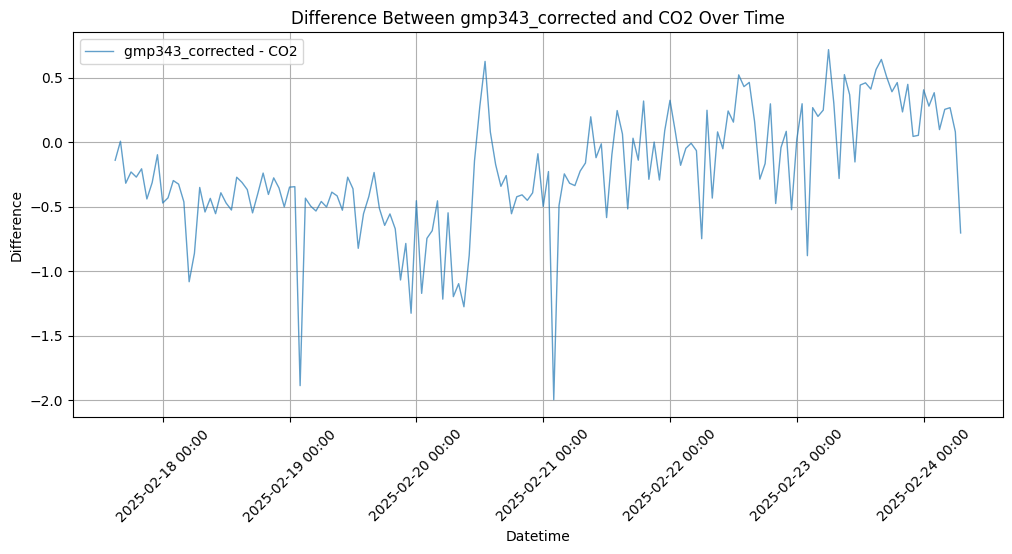

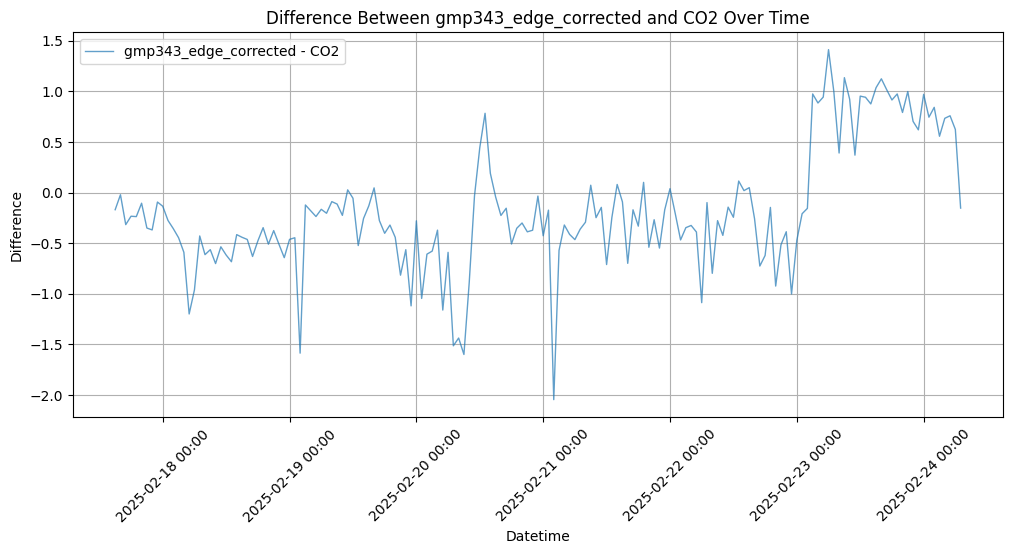

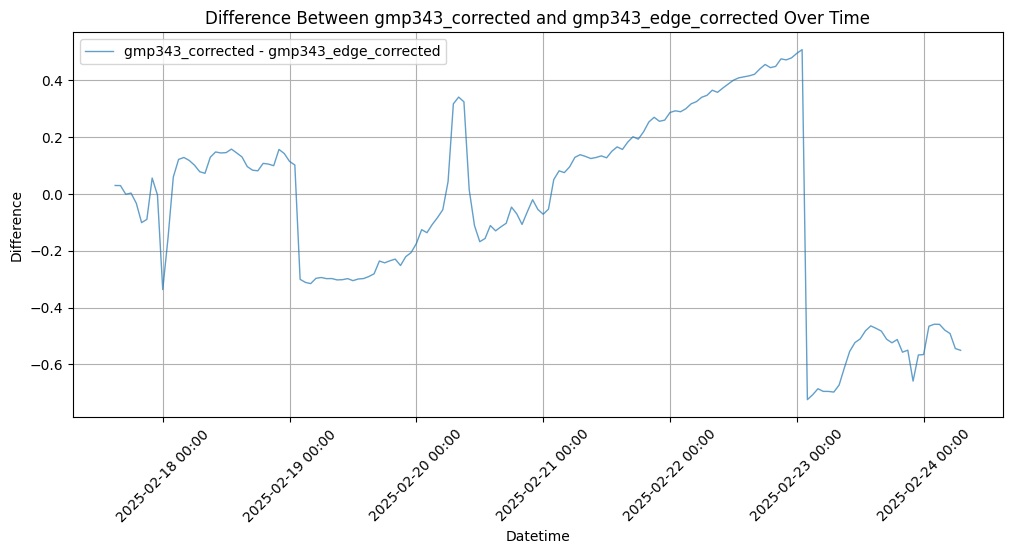

In [28]:
plot_column_difference(df_3, datetime_col="datetime", col1="gmp343_corrected", col2="CO2", sample_size=100_000)
plot_column_difference(df_3, datetime_col="datetime", col1="gmp343_edge_corrected", col2="CO2", sample_size=100_000)
plot_column_difference(df_3, datetime_col="datetime", col1="gmp343_corrected", col2="gmp343_edge_corrected", sample_size=100_000)

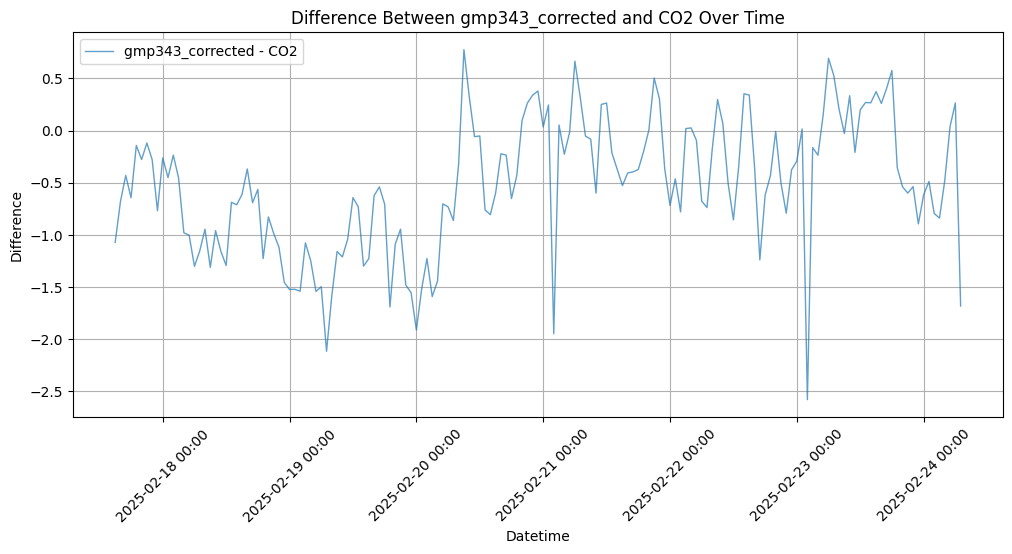

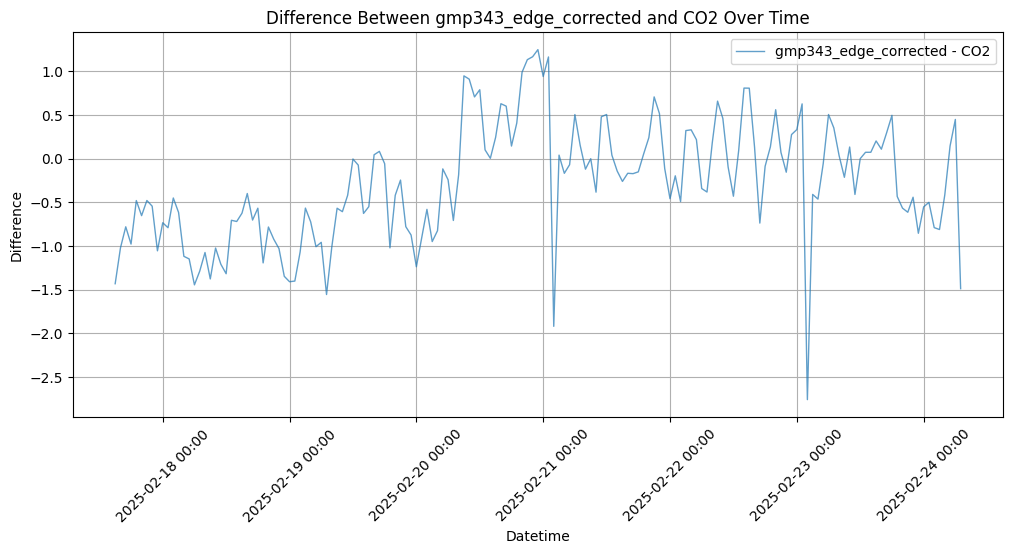

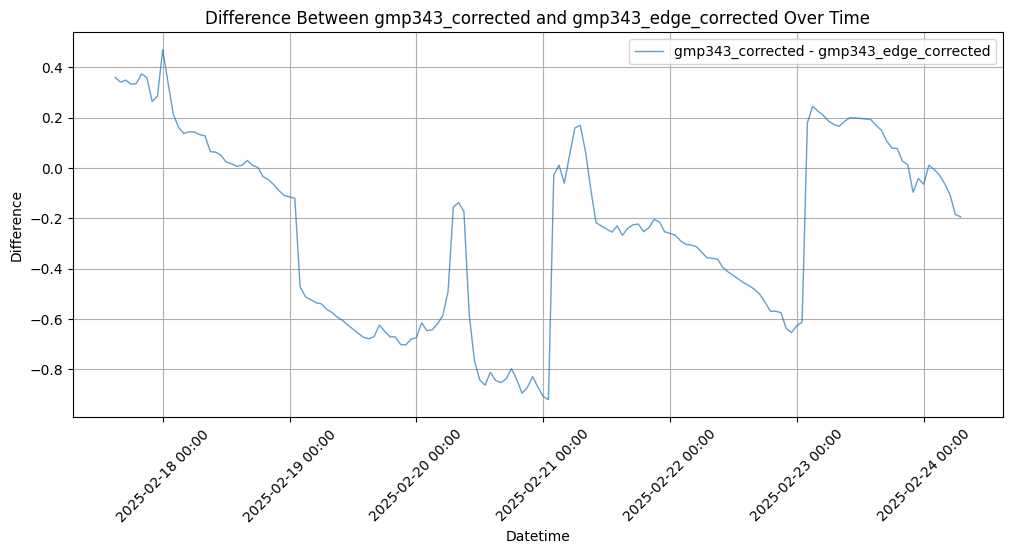

In [29]:
plot_column_difference(df_6, datetime_col="datetime", col1="gmp343_corrected", col2="CO2", sample_size=100_000)
plot_column_difference(df_6, datetime_col="datetime", col1="gmp343_edge_corrected", col2="CO2", sample_size=100_000)
plot_column_difference(df_6, datetime_col="datetime", col1="gmp343_corrected", col2="gmp343_edge_corrected", sample_size=100_000)

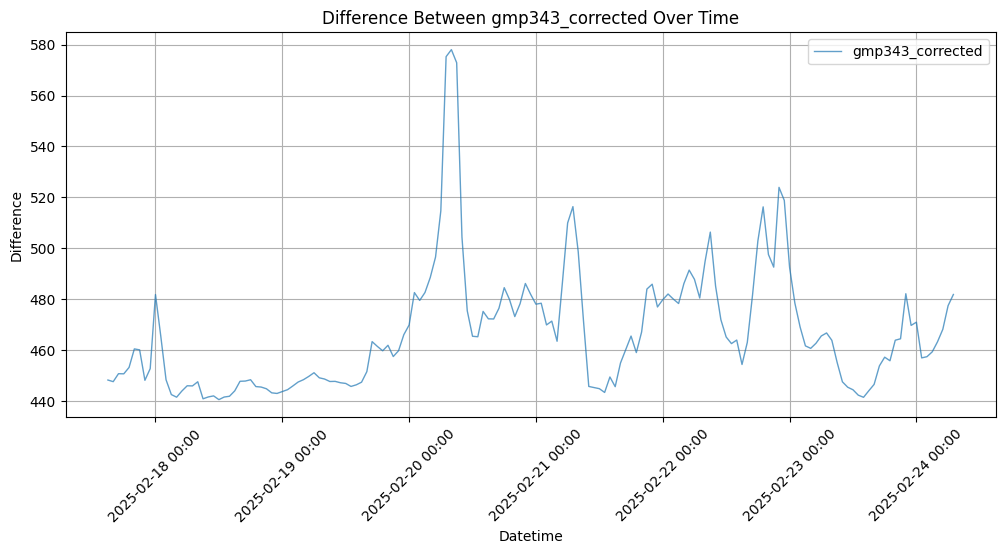

In [30]:
plot_column(df_6, datetime_col="datetime", col1="gmp343_corrected", sample_size=100_000)